### Importing Packages

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

#### Importing the Data

In [53]:
df = pd.read_csv('..\Data\Train_TEC_mar17.csv')
# df = pd.read_csv('../Data/TotalWithMissing.csv')

In [54]:
df.head()

,Date,Month,Year,Time,LT,TEC
0,1,3,2017,0.016389,5.311333,2.067562
1,1,3,2017,0.049722,5.344670,2.082707
2,1,3,2017,0.083056,5.378006,2.004272
3,1,3,2017,0.116389,5.411343,1.736569
4,1,3,2017,0.149722,5.444679,1.758503


#### Dropping Useless columns

In [55]:
df.drop(["Date","Month","Year","Time","LT"], axis = 1, inplace = True)

In [56]:
df.head()

,TEC
0,2.067562
1,2.082707
2,2.004272
3,1.736569
4,1.758503


#### Converting it into a ndarray

In [57]:
training_set = df.iloc[:,:].values

In [58]:
type(training_set), training_set.shape

(numpy.ndarray, (14400, 1))

#### Plotting the Data

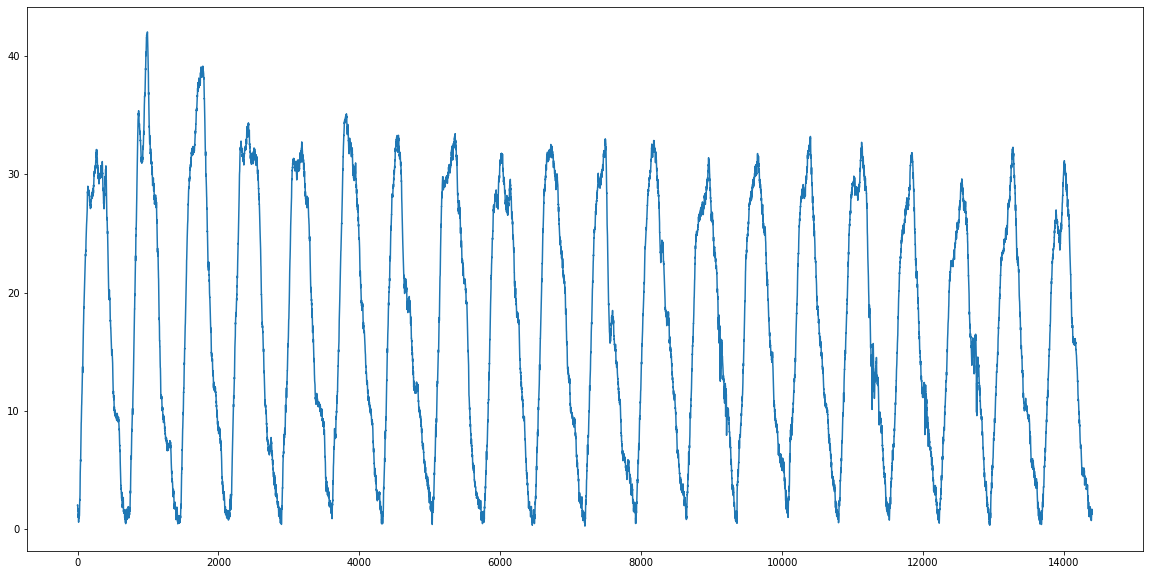

In [59]:
plt.figure(figsize=(20,10))

plt.plot(training_set, label = 'TEC Values')
plt.show()

#### Making Data Sequential for look back

In [60]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()

training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.90)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [61]:
training_data[-5:],x[0].shape, x[0], x[1], y

(array([[0.03427839],
        [0.03276266],
        [0.02464814],
        [0.02412893],
        [0.03227832]]),
 (4, 1),
 array([[0.04266831],
        [0.04303103],
        [0.04115251],
        [0.03474105]]),
 array([[0.04303103],
        [0.04115251],
        [0.03474105],
        [0.03526637]]),
 array([[0.03526637],
        [0.03025557],
        [0.03485417],
        ...,
        [0.03276266],
        [0.02464814],
        [0.02412893]]))

In [62]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [63]:
# num_epochs = 1000
num_epochs = 90
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()   
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 1 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.06268
Epoch: 1, loss: 0.06109
Epoch: 2, loss: 0.05969
Epoch: 3, loss: 0.05843
Epoch: 4, loss: 0.05717
Epoch: 5, loss: 0.05575
Epoch: 6, loss: 0.05415
Epoch: 7, loss: 0.05243
Epoch: 8, loss: 0.05063
Epoch: 9, loss: 0.04881
Epoch: 10, loss: 0.04695
Epoch: 11, loss: 0.04499
Epoch: 12, loss: 0.04290
Epoch: 13, loss: 0.04067
Epoch: 14, loss: 0.03831
Epoch: 15, loss: 0.03587
Epoch: 16, loss: 0.03337
Epoch: 17, loss: 0.03082
Epoch: 18, loss: 0.02821
Epoch: 19, loss: 0.02550
Epoch: 20, loss: 0.02272
Epoch: 21, loss: 0.01989
Epoch: 22, loss: 0.01710
Epoch: 23, loss: 0.01438
Epoch: 24, loss: 0.01173
Epoch: 25, loss: 0.00919
Epoch: 26, loss: 0.00685
Epoch: 27, loss: 0.00483
Epoch: 28, loss: 0.00315
Epoch: 29, loss: 0.00183
Epoch: 30, loss: 0.00095
Epoch: 31, loss: 0.00055
Epoch: 32, loss: 0.00060
Epoch: 33, loss: 0.00098
Epoch: 34, loss: 0.00160
Epoch: 35, loss: 0.00233
Epoch: 36, loss: 0.00298
Epoch: 37, loss: 0.00344
Epoch: 38, loss: 0.00367
Epoch: 39, loss: 0.00364
Epoch: 40,

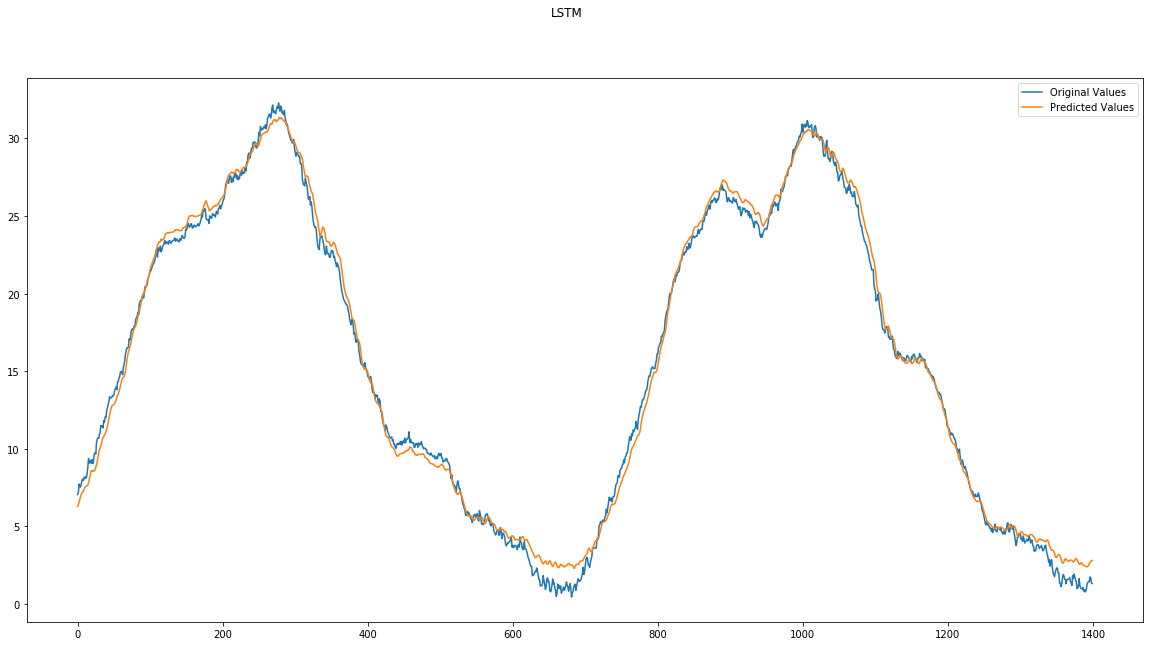

In [76]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(20,10))

plt.plot(dataY_plot[-1400:], Label= "Original Values")
plt.plot(data_predict[-1400:], Label= "Predicted Values")
plt.legend()
plt.suptitle('LSTM')
plt.show()

In [70]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(dataY_plot, data_predict))

rms

0.8421669343549961

In [65]:
dataY_plot.shape, data_predict.shape

((14395, 1), (14395, 1))

In [66]:
train_predict.shape

torch.Size([14395, 1])

In [67]:
dataY_plot.shape

(14395, 1)

In [68]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(dataY_plot, data_predict))

rms

0.8421669343549961

In [78]:
dataY_plot.shape

(14395, 1)

In [81]:
df_new = df[:14395]

In [84]:
df_new["Predicted TEC Values"] = dataY_plot

C:\Users\yash\Miniconda3\envs\TEC\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
df_new

,TEC,Predicted TEC Values
0,2.067562,1.758503
1,2.082707,1.549283
2,2.004272,1.741292
3,1.736569,1.360906
4,1.758503,1.055326
...,...,...
14390,0.984328,1.417214
14391,1.272465,1.717251
14392,1.367957,1.653964
14393,1.420582,1.315151


In [87]:
df_new.to_csv("PredictedTEC.csv", index=False)